In [27]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import scipy.io as spio

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib as mpl
import seaborn as sns

import skimage.morphology as morph

import homology

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
sns.set(color_codes=True, palette='deep')
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

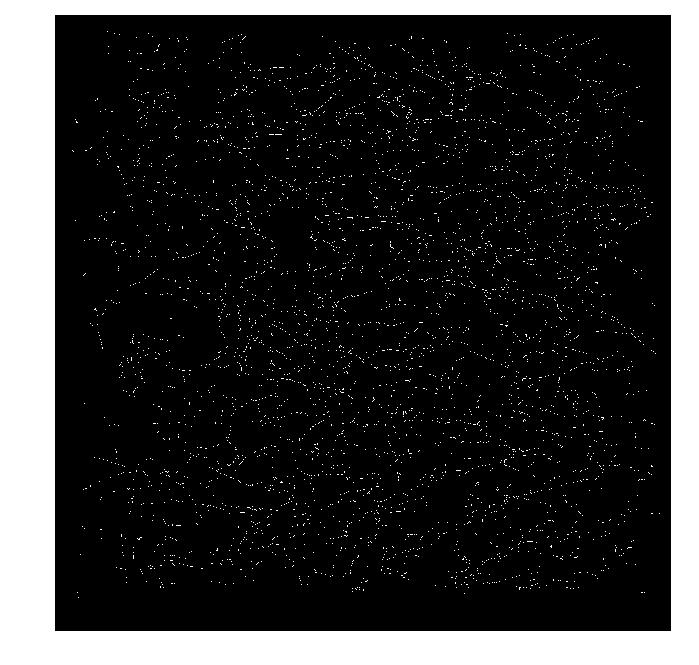

In [28]:
mat = spio.loadmat("../sample_data/Creases17.mat")

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(mat['ridges'], cmap=plt.cm.gray)
ax.axis('off')
plt.show()

In [29]:
print(mat['ridges'].shape)
data = mat['ridges'][0:1000, 0:1000]

Nx = data.shape[0]
Ny = data.shape[1]

simplices = np.arange(Nx*Ny)
dims = np.full(Nx*Ny, 2)
boundaries = {i+1:[] for i in range(2)}

for i in range(Nx):
    for j in range(Ny+1):
        boundaries[1].append([Nx*j + i, Nx*j + i+1])
        
for i in range(Nx+1):
    for j in range(Ny):
        boundaries[1].append([Nx*j + i, Nx*(j+1) + i])
        

for i in range(Nx):
    for j in range(Ny):
        boundaries[2].append([Nx*j + i, Nx*(Ny+1) + (Nx+1)*j + i+1, Nx*(j+1) + i, Nx*(Ny+1) + (Nx+1)*j + i])
        


(3000, 3000)


Height: 0
Zeros: 990156


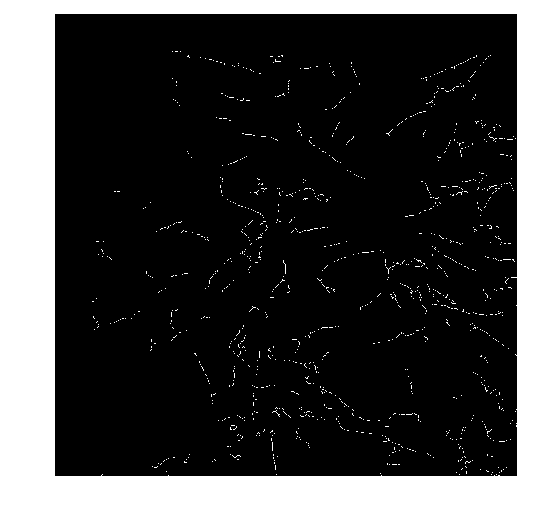

Height: 1
Zeros: 906353


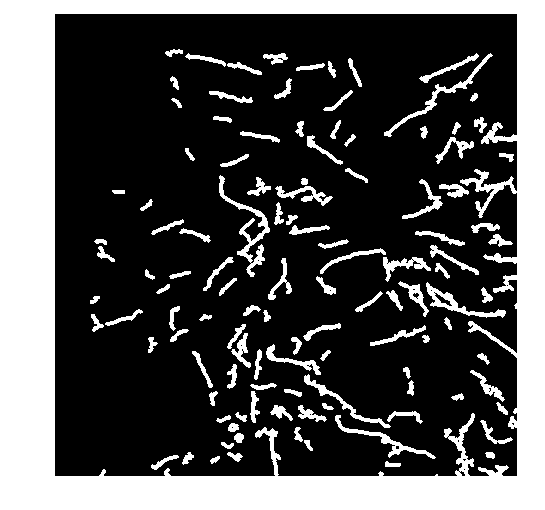

Height: 2
Zeros: 820778


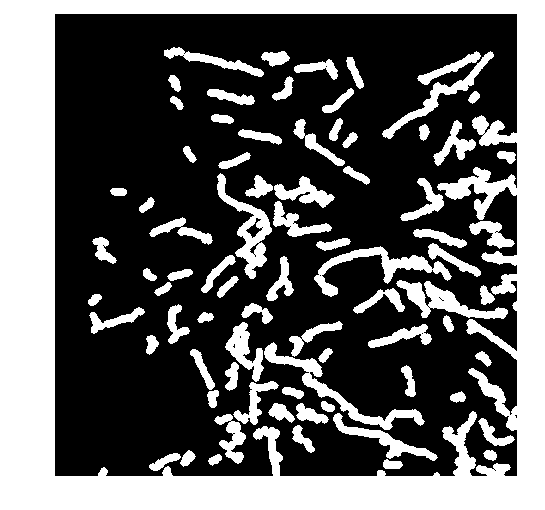

Height: 3
Zeros: 735092


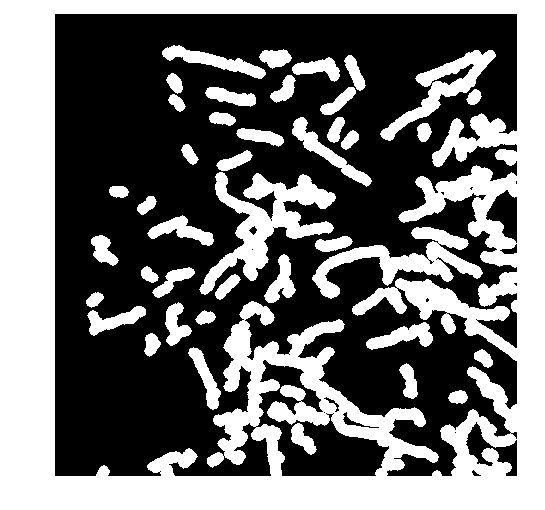

Height: 4
Zeros: 652944


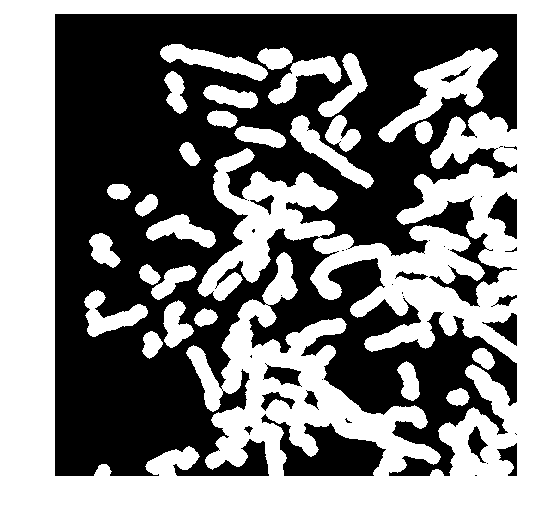

Height: 5
Zeros: 577131


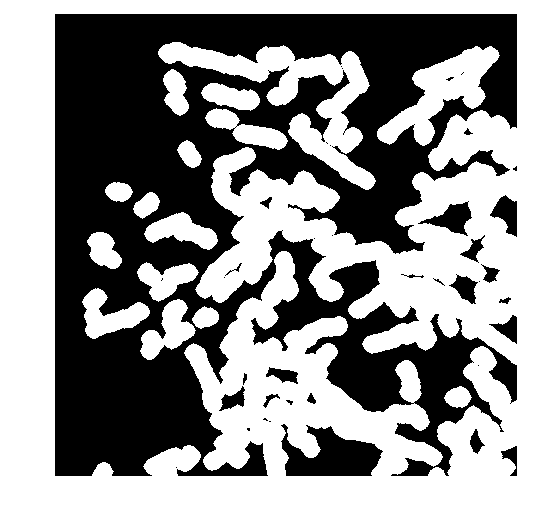

Height: 6
Zeros: 509418


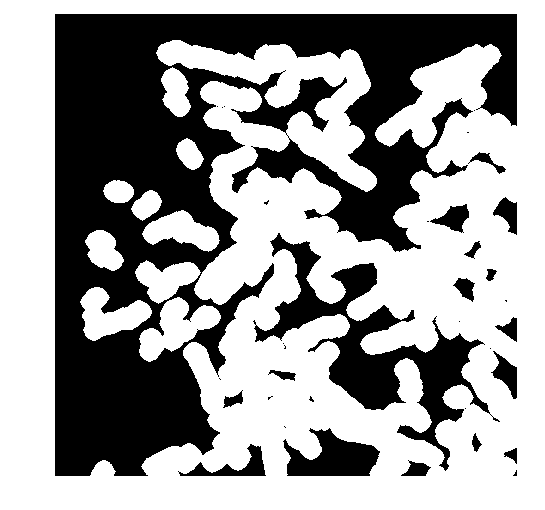

Height: 7
Zeros: 449467


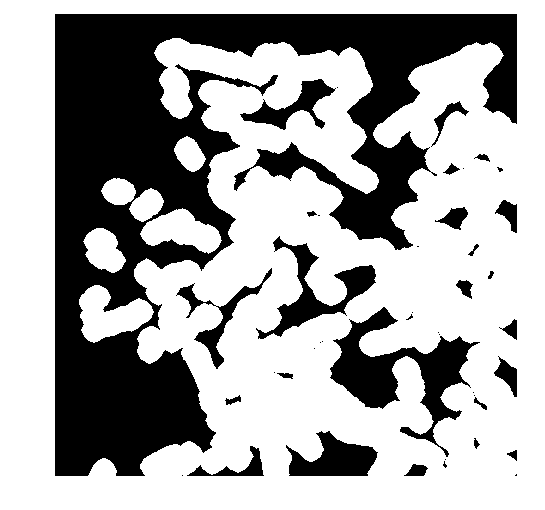

Height: 8
Zeros: 397153


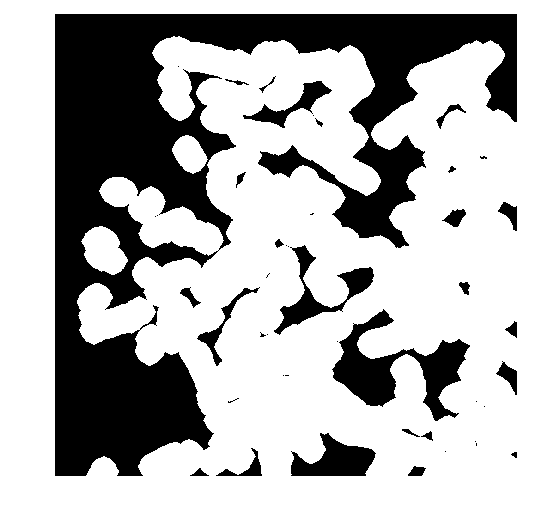

Height: 9
Zeros: 353453


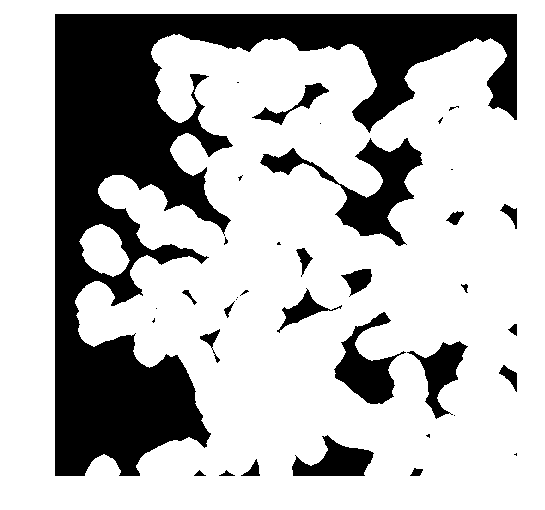

Height: 10
Zeros: 317144


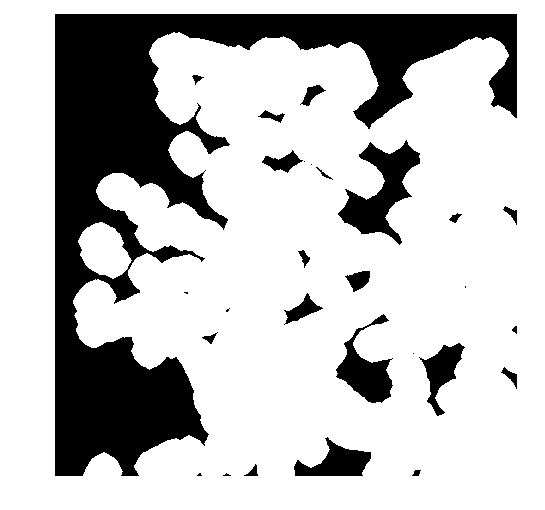

Height: 11
Zeros: 286529


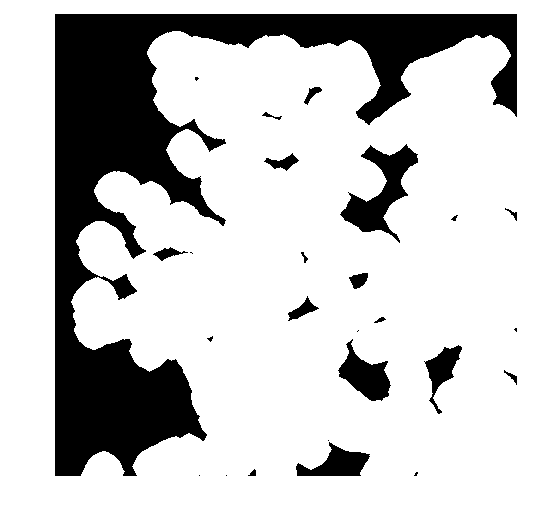

Height: 12
Zeros: 260410


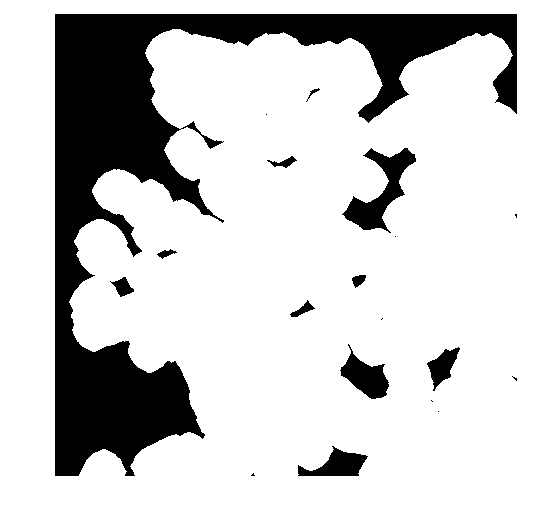

Height: 13
Zeros: 238308


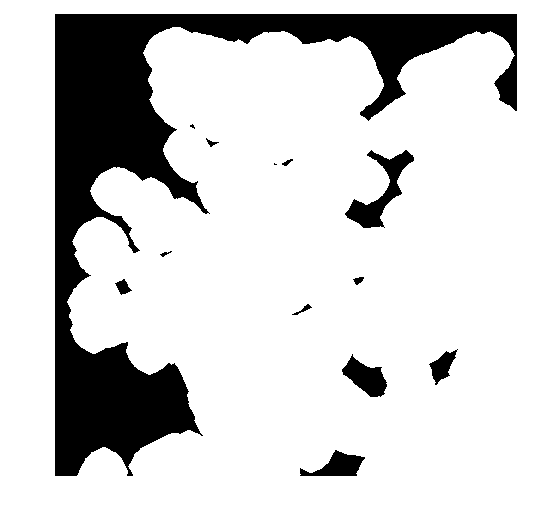

Height: 14
Zeros: 218813


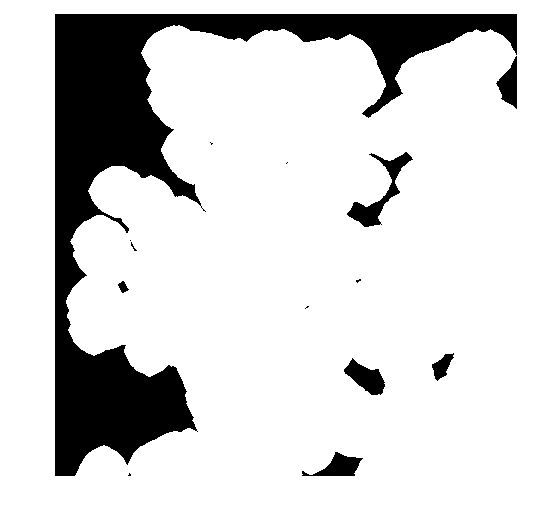

Height: 15
Zeros: 201614


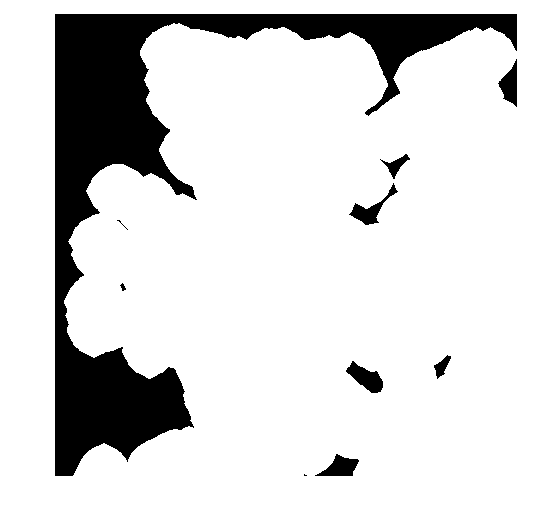

Height: 16
Zeros: 186303


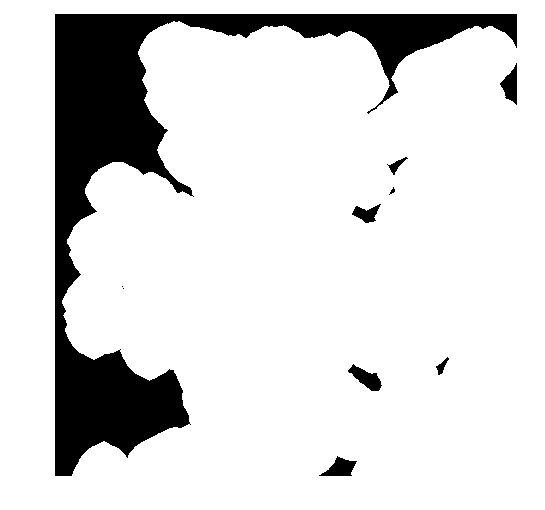

Height: 17
Zeros: 172476


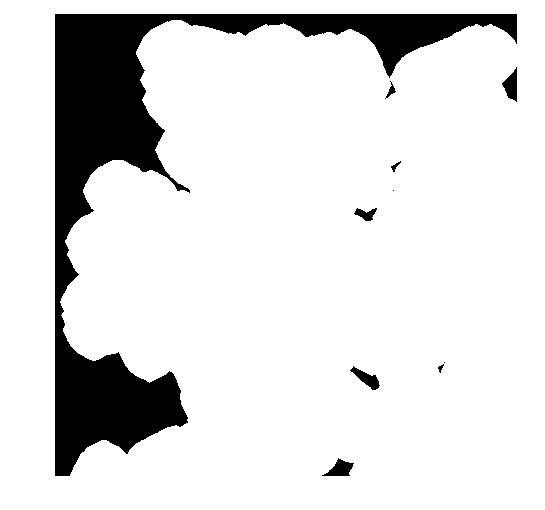

Height: 18
Zeros: 160015


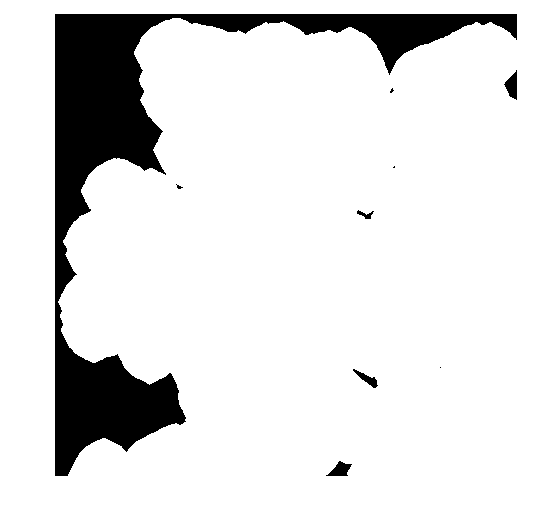

Height: 19
Zeros: 148858


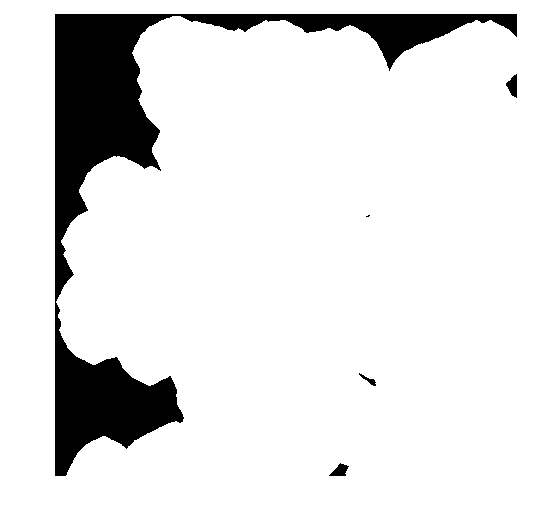

Height: 20
Zeros: 138543


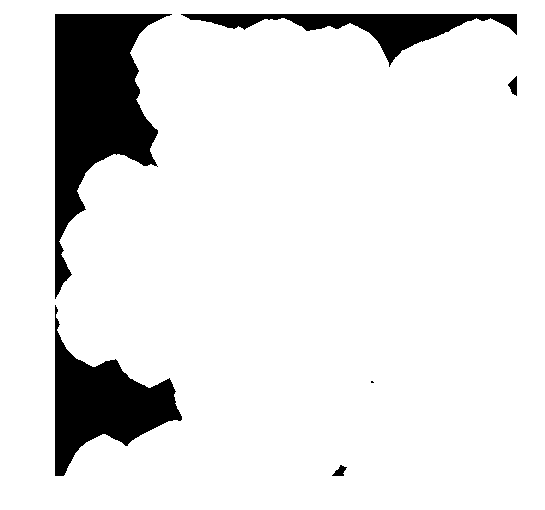

Height: 21
Zeros: 128841


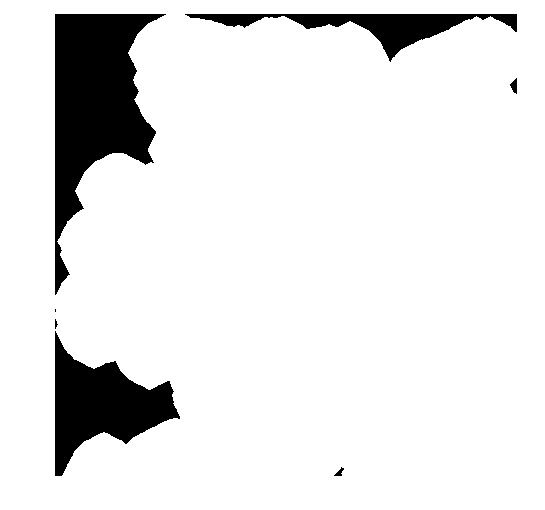

Height: 22
Zeros: 119607


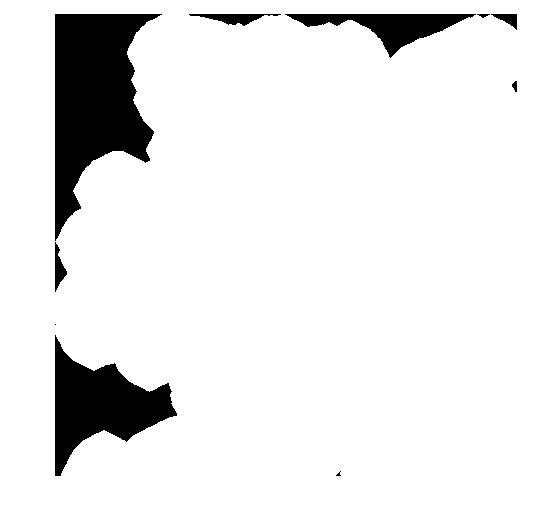

Height: 23
Zeros: 110928


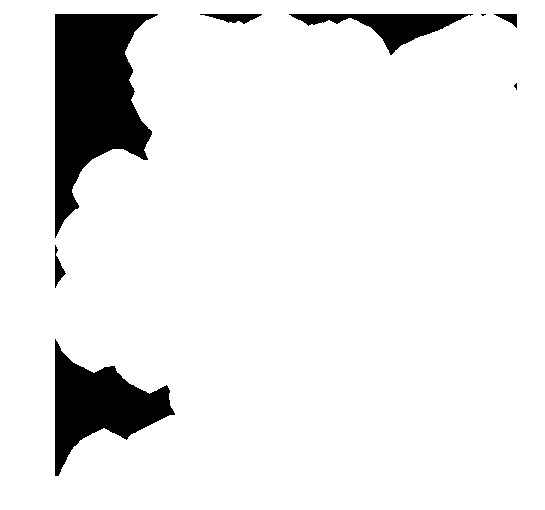

Height: 24
Zeros: 102954


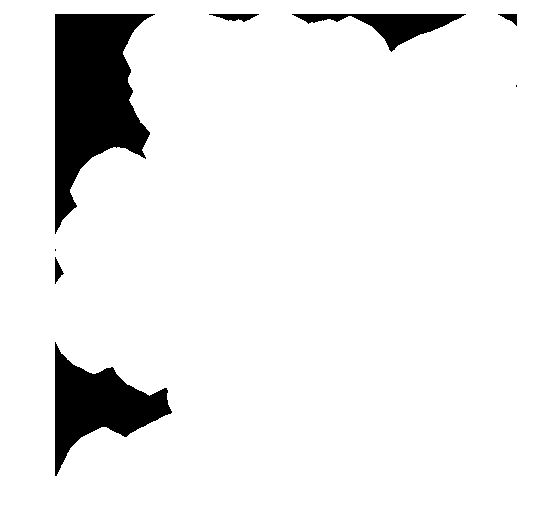

Height: 25
Zeros: 95560


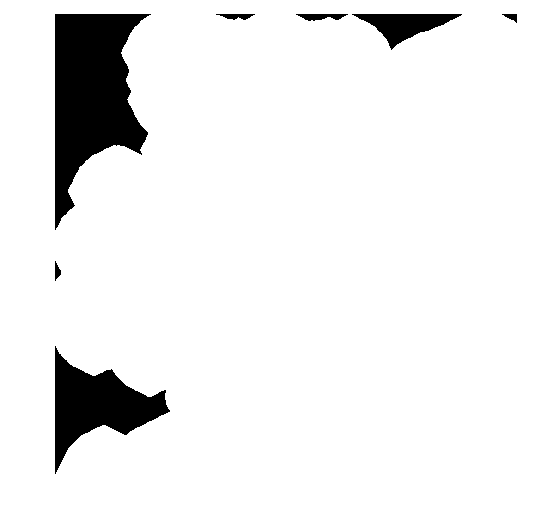

Height: 26
Zeros: 88671


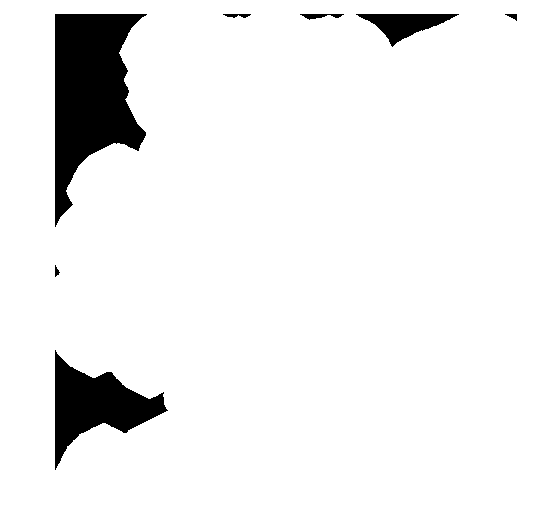

Height: 27
Zeros: 82306


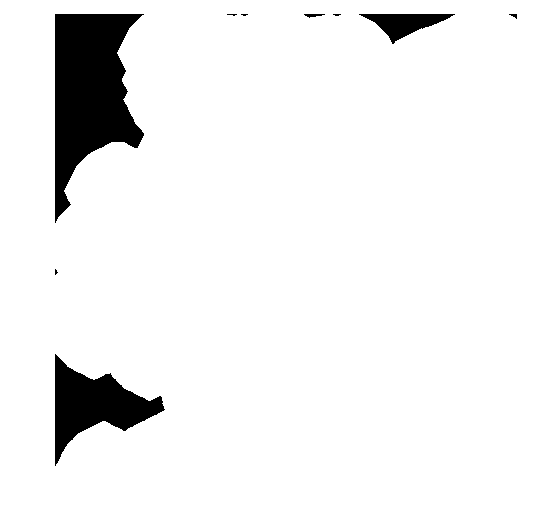

Height: 28
Zeros: 76517


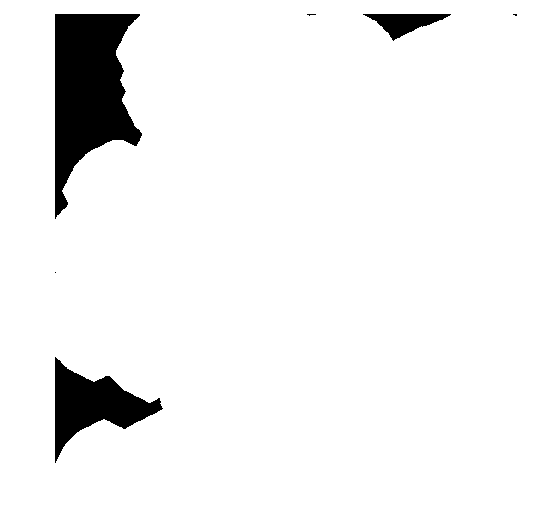

Height: 29
Zeros: 71292


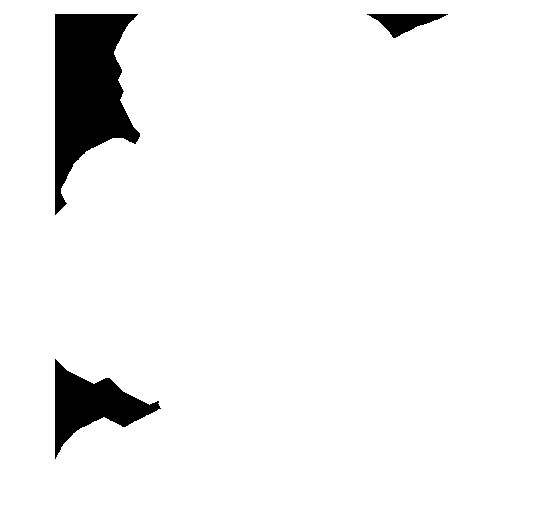

Height: 30
Zeros: 66350


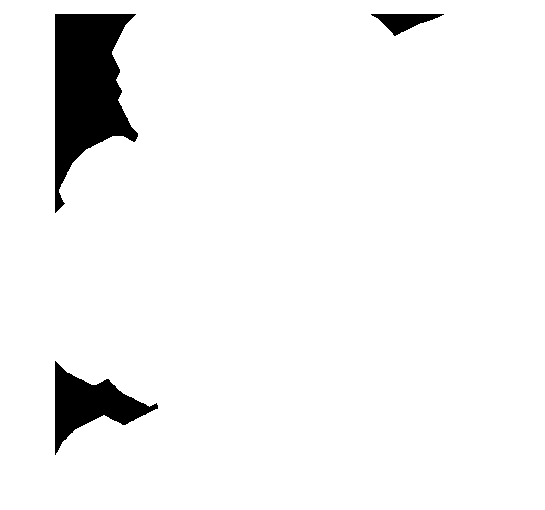

Height: 31
Zeros: 61595


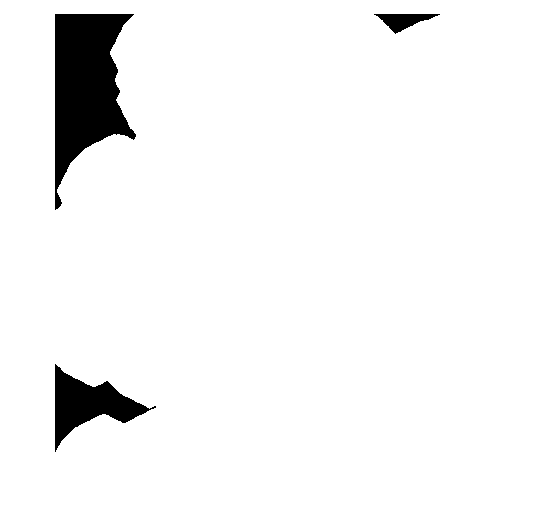

Height: 32
Zeros: 57063


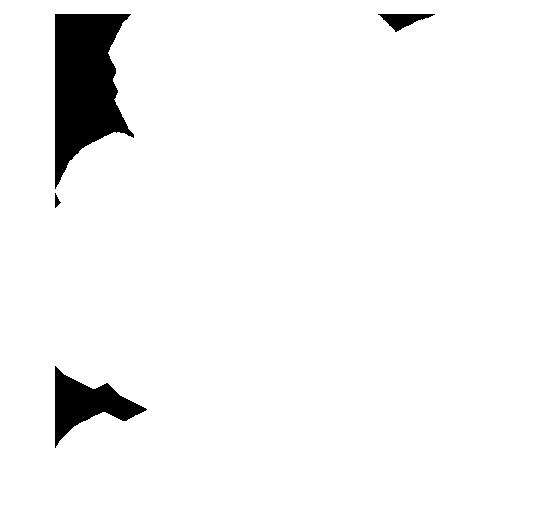

In [30]:
heights = np.zeros(Nx*Ny, float)

curr_height = 0

num_zeros = np.count_nonzero(data==0)

print("Height:", curr_height)
print("Zeros:", num_zeros)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(data, cmap=plt.cm.gray)
ax.axis('off')
plt.show()


while num_zeros > 0:
    
    curr_height += 1

    selem = morph.disk(4)
    dilated = morph.dilation(data, selem)
        
    new_nonzeros = np.nonzero((dilated - data).flatten())[0]
                
    num_zeros -= len(new_nonzeros)
    
    print("Height:", curr_height)
    print("Zeros:", num_zeros)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(dilated, cmap=plt.cm.gray)
    ax.axis('off')
    plt.show()
    
    heights[new_nonzeros] = curr_height
        
    data = dilated
    
    if curr_height >= 32:
        break

In [31]:
(ibirth, ideath, pheight, persist, sim_to_pindex) = homology.compute_persistence_pairs(
    simplices, dims, heights, boundaries)

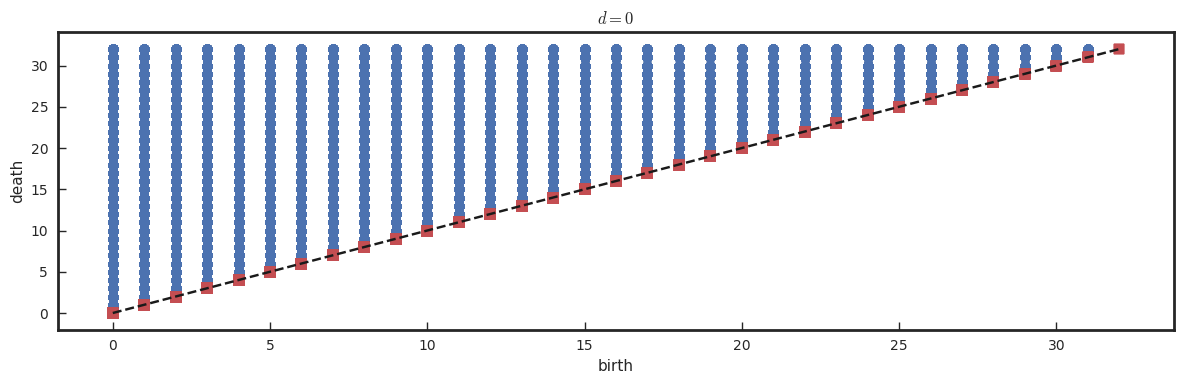

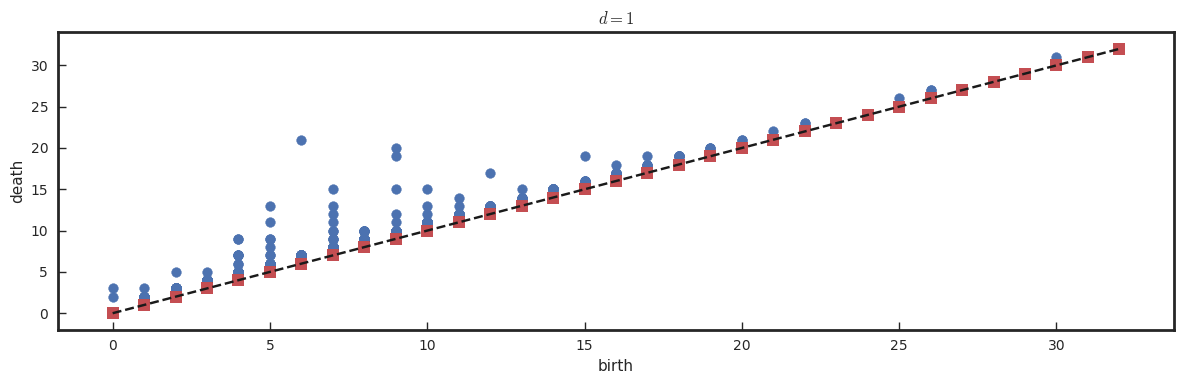

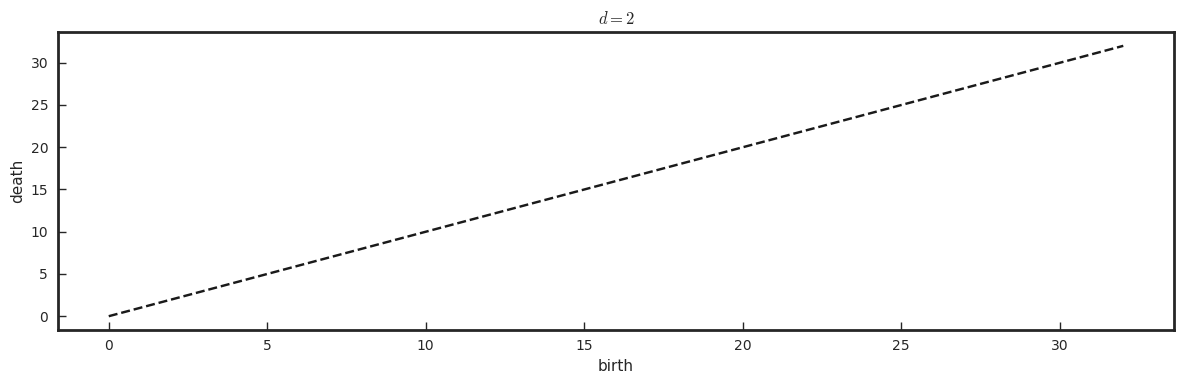

In [32]:
birth = [[] for i in range(3)]
for d in range(3):
    for i in ibirth[d]:
        birth[d].append(pheight[i])

death = [[] for i in range(3)]
for d in range(3):
    for i in ideath[d]:
        death[d].append(pheight[i])

pbirth = [[] for i in range(3)]
for d in range(3):
    for i in persist[d]:
        pbirth[d].append(pheight[i])

    
for d in range(3):
    
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1,1,1)

    ax1.scatter(birth[d], death[d], marker='o', color='b')
    
    ax1.scatter(pbirth[d], pbirth[d], marker='s', color='r')

    ax1.plot(np.linspace(0, curr_height, 100), np.linspace(0, curr_height, 100), 'k--')
    
    ax1.set_title(r"$d={}$".format(d))

#     ax1.set_xlim(1e1, 1e-7)
#     ax1.set_ylim(1e1, 1e-7)

    
#     ax1.set_xscale('log')
#     ax1.set_yscale('log')
    
    ax1.set_xlabel(r"birth")
    ax1.set_ylabel(r"death")
    
    plt.tight_layout()

    plt.show()